In [1]:
import os
#os.environ["JAX_PLATFORMS"] = "cpu"  # Forces JAX to run on CPU

import jax #pip install jax
print(f"JAX is using: {jax.devices()[0]}")
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax #pip install distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import jaxmarl
from jaxmarl.wrappers.baselines import LogWrapper
from jaxmarl.environments.overcooked import Overcooked, overcooked_layouts, layout_grid_to_dict
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
from jaxmarl import make
import hydra #pip install hydra-core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt

### Added to modify the structure of the definitions
from functools import partial

JAX is using: TFRT_CPU_0


In [2]:
import jax.lax as lax
import pickle
from datetime import datetime
from PIL import Image
import time
import re
from textwrap import dedent
import csv
import pandas as pd
import sys

# Save the model parameters only
def save_model(runner_state, save_dir, file):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Construct the full file path
    filename = os.path.join(save_dir, file)

    # Extract train_state (first element of the tuple)
    train_state_1 = runner_state[0]
    train_state_2 = runner_state[1]

    # Save only the model parameters
    with open(filename, 'wb') as f:
        pickle.dump({'params_1': train_state_1.params, 
                     'params_2': train_state_2.params}, f)


    print(f"Model parameters saved to {filename}")

# Load the model parameters
def load_model(load_dir, file):
    filename = os.path.join(load_dir, file)

    if not os.path.exists(filename):
        raise FileNotFoundError(f"Model file {filename} not found.")

    with open(filename, "rb") as f:
        saved_data = pickle.load(f)

    # Ensure the loaded model has the correct parameter structure
    if "params_1" not in saved_data or "params_2" not in saved_data:
        raise ValueError("Invalid saved model file.")

    model_params_1 = saved_data["params_1"]
    model_params_2 = saved_data["params_2"]
    print(f"Model parameters loaded from {filename}")

    return model_params_1, model_params_2

In [3]:
def choose_tx(config):
    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac
    
    if config["ANNEAL_LR"]:
        tx = optax.chain(
            optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
            optax.adam(learning_rate=linear_schedule, eps=1e-5),
        )
    else:
        tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
    
    return tx

def find_closest_checkpoint(fixed_step, load_dir):
    # List all files in the directory
    files = os.listdir(load_dir)
    
    # Filter files that match the pattern 'trained_model_{step}.pkl'
    checkpoint_files = [f for f in files if f.startswith("trained_model_") and f.endswith(".pkl")]
    
    # Extract the step numbers from the filenames
    steps = []
    for file in checkpoint_files:
        step_str = file.split('_')[-1].split('.')[0]  # Extract the step number
        try:
            step = int(step_str)
            steps.append(step)
        except ValueError:
            continue  # Skip files that don't have a valid step number
    
    if len(steps) == 0:
        raise FileNotFoundError(f"No checkpoint files found in {load_dir}")
    
    # Find the closest step to the fixed step
    closest_step = min(steps, key=lambda x: abs(x - fixed_step))
    closest_filename = f"trained_model_{closest_step}.pkl"
    
    print(f"Found checkpoint: {closest_filename} for step {closest_step}")
    
    # Load the model (assuming load_model function is available)
    model_params_1, model_params_2 = load_model(load_dir, closest_filename)
    
    return model_params_1, model_params_2, closest_step

import imageio.v3 as iio

def custom_animate(state_seq, agent_view_size, filename="animation.gif"):
    """Animate a GIF give a state sequence and save if to file."""
    import imageio
    TILE_PIXELS = 32

    padding = agent_view_size - 2  # show

    def get_frame(state):
            grid = np.asarray(state.maze_map[padding:-padding, padding:-padding, :])
            # Render the state
            frame = OvercookedVisualizer._render_grid(
                    grid,
                    tile_size=TILE_PIXELS,
                    highlight_mask=None,
                    agent_dir_idx=state.agent_dir_idx,
                    agent_inv=state.agent_inv
            )
            return frame

    frame_seq =[get_frame(state) for state in state_seq]
    
    imageio.mimsave(filename, frame_seq, 'GIF', duration=2)
    
def gif_to_mp4(gif_filename):
    """Convert a GIF to MP4 using imageio and ffmpeg."""
    mp4_filename = gif_filename.replace(".gif", ".mp4")
    gif = iio.imread(gif_filename)
    fps = 2  # Set desired FPS

    iio.imwrite(mp4_filename, gif, extension=".mp4", fps=fps)
    print(f"MP4 saved to {mp4_filename}")

In [4]:
class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"
    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu

        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

In [5]:
def reshape_info(info):
    def reshape_fn(x):
        if isinstance(x, dict):
            return jax.tree.map(lambda y: y.reshape(-1), x)
        # For (8, 2) shaped arrays, reshape to (16,)
        elif len(x.shape) == 2 and x.shape[1] == 2:
            return x.reshape(-1)
        # For (8,) shaped arrays
        else:
            # Repeat each element twice since we have 2 agents
            return jnp.repeat(x, 2)
    return jax.tree.map(reshape_fn, info)

In [6]:
def split_info(info):
    def split_fn_agent_0(x):
        if isinstance(x, dict):
            return jax.tree.map(lambda y: y[:, 0], x)
        # For (8, 2) shaped arrays, reshape to (16,)
        elif len(x.shape) == 2 and x.shape[1] == 2:
            return x[:, 0]
        # For (8,) shaped arrays
        else:
            # Repeat each element twice since we have 2 agents
            return x

    def split_fn_agent_1(x):
        if isinstance(x, dict):
            return jax.tree.map(lambda y: y[:, 1], x)
        # For (8, 2) shaped arrays, reshape to (16,)
        elif len(x.shape) == 2 and x.shape[1] == 2:
            return x[:, 1]
        # For (8,) shaped arrays
        else:
            # Repeat each element twice since we have 2 agents
            return x

    return jax.tree.map(split_fn_agent_0, info), jax.tree.map(split_fn_agent_1, info)


def merge_info(info_1, info_2):
    def merge_fn(x_1, x_2):
        if isinstance(x_1, dict):
            # If the values are dictionaries, recursively merge them
            return jax.tree.map(merge_fn, x_1, x_2)
        else:
            # For array values, stack them along a new axis (axis=1)
            return jnp.stack([x_1, x_2], axis=1)

    # Use tree map to merge corresponding elements from both dictionaries
    return jax.tree.map(merge_fn, info_1, info_2)

In [7]:
def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))

def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

In [8]:
def make_config(config):
    """Enhances config with additional computed parameters and prints it in a readable format."""
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    # Compute additional parameters
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = int(config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"])
    config["NUM_SAVES"] = int(config["NUM_UPDATES"] // config["SAVE_EVERY_N_EPOCHS"])
    config["MINIBATCH_SIZE"] = (
        int(config["NUM_ACTORS"] / 2) * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )

    # Print all configuration settings in a structured way
    print("\n===== CONFIGURATION SETTINGS =====")
    for key in sorted(config.keys()):  # Sort keys alphabetically for readability
        print(f"{key}: {config[key]}")
    print("==================================\n")

    return config


In [9]:
def make_train(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(seed, rng, initial_dir, csv_file_path):

        # INIT NETWORK

        # Creates an instance of the ActorCritic model.
        # The ActorCritic class is initialized with:
        # env.action_space().n: The number of possible actions in the environment.
        # config["ACTIVATION"]: The type of activation function to use (e.g., ReLU or Tanh).
        network_1 = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
        network_2 = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])

        # Splits the random number generator rng into two separate RNGs (rng and _rng), so they can be used independently.
        rng, _rng = jax.random.split(rng)
        _rng_1, _rng_2 = jax.random.split(_rng)

        # Creates a zero-initialized array of the same shape as the observation space of the environment (env.observation_space().shape), then flattens it into a 1D array (init_x).
        # This serves as a sample input to initialize the network.
        init_x = jnp.zeros(env.observation_space().shape)
        init_x = init_x.flatten()

        # Initializes the parameters of the network (network_params) by passing the random key _rng and the input init_x (observation example).
        # This is necessary to set up the weights and biases of the neural network layers.
        network_1_params = network_1.init(_rng_1, init_x)
        network_2_params = network_2.init(_rng_2, init_x)

        # This block initializes the optimizer (tx) that will be used to update the network parameters.
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))

        # Creates a TrainState object that holds the model's parameters (network_params), the optimizer (tx), and the function to apply the model (network.apply).
        # This will be used for model training, including parameter updates.
        train_state_1 = TrainState.create(
            apply_fn=network_1.apply,
            params=network_1_params,
            tx=tx,
        )

        train_state_2 = TrainState.create(
            apply_fn=network_2.apply,
            params=network_2_params,
            tx=tx,
        )

        # INIT ENV
        # Splits the RNG (rng) into two new RNGs: one (_rng) used for resetting the environment, and another (reset_rng) for each environment if you're running multiple environments in parallel (config["NUM_ENVS"]).
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])

        # Initializes the environment(s). jax.vmap is used to vectorize the env.reset function, so it can reset config["NUM_ENVS"] environments in parallel.
        # reset_rng: The random keys for resetting each environment are passed in here.
        # obsv: The initial observations returned by the environment(s).
        # env_state: The initial state of the environment(s).
        obsv, env_state = jax.vmap(env.reset, in_axes=(0,))(reset_rng)

        # TRAIN LOOP
        @jax.jit
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES

            # Action Selection: It uses the current policy (pi) to sample an action based on the current observations.
            # Environment Step: It then steps the environment using the selected actions, receiving observations, rewards, done flags, and additional info.
            # Transition Recording: A transition is created, which includes the action taken, value estimate, rewards, and log probabilities for the action. This transition is used to calculate losses later.

            def _env_step(runner_state, unused):
                train_state_1, train_state_2, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                _rng_1, _rng_2 = jax.random.split(_rng)

                # obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
                pi_1, value_1 = network_1.apply(train_state_1.params, jnp.array(last_obs[env.agents[0]]).reshape((int(config["NUM_ACTORS"]/2), -1)))
                pi_2, value_2 = network_2.apply(train_state_2.params, jnp.array(last_obs[env.agents[1]]).reshape((int(config["NUM_ACTORS"]/2), -1)))

                action_1 = pi_1.sample(seed=_rng_1)
                log_prob_1 = pi_1.log_prob(action_1)

                action_2 = pi_2.sample(seed=_rng_2)
                log_prob_2 = pi_2.log_prob(action_2)

                action = jnp.concatenate([action_1, action_2], axis=0)

                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                env_act = {k:v.flatten() for k,v in env_act.items()}

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0))(
                    rng_step, env_state, env_act
                )

                info_1, info_2 = split_info(info)

                transition_1 = Transition(
                    jnp.array(done[env.agents[0]]).reshape((int(config["NUM_ACTORS"]/2), -1)).squeeze(),
                    action_1,
                    value_1,
                    jnp.array(reward[env.agents[0]]).reshape((int(config["NUM_ACTORS"]/2), -1)).squeeze(),
                    log_prob_1,
                    jnp.array(last_obs[env.agents[0]]).reshape((int(config["NUM_ACTORS"]/2), -1)),
                    info_1
                )
                transition_2 = Transition(
                    jnp.array(done[env.agents[1]]).reshape((int(config["NUM_ACTORS"]/2), -1)).squeeze(),
                    action_2,
                    value_2,
                    jnp.array(reward[env.agents[1]]).reshape((int(config["NUM_ACTORS"]/2), -1)).squeeze(),
                    log_prob_2,
                    jnp.array(last_obs[env.agents[1]]).reshape((int(config["NUM_ACTORS"]/2), -1)),
                    info_2
                )
                runner_state = (train_state_1, train_state_2, env_state, obsv, rng)
                return runner_state, (transition_1, transition_2)

            # This line performs the _env_step function repeatedly for NUM_STEPS. jax.lax.scan is a JAX function that allows you to apply a function repeatedly over a sequence of data, which is used here to simulate multiple environment interactions (collecting trajectories for NUM_STEPS).
            runner_state, (traj_batch_1, traj_batch_2) = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            # After collecting the trajectory, this part calculates the advantages of each transition using GAE. The last observation (last_obs) is passed through the network to get the value (last_val) for the last state.
            train_state_1, train_state_2, env_state, last_obs, rng = runner_state
            # last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

            _, last_val_1 = network_1.apply(train_state_1.params, last_obs[env.agents[0]].reshape((int(config["NUM_ACTORS"]/2), -1)))
            _, last_val_2 = network_2.apply(train_state_2.params, last_obs[env.agents[1]].reshape((int(config["NUM_ACTORS"]/2), -1)))

            # This function implements the GAE algorithm to compute advantages and targets (the value targets).
            # delta is computed using the Bellman equation for each transition.
            # gae is calculated iteratively in reverse order of the trajectory, allowing for more stable learning by incorporating multiple future rewards.
            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages_1, targets_1 = _calculate_gae(traj_batch_1, last_val_1)
            advantages_2, targets_2 = _calculate_gae(traj_batch_2, last_val_2)

            # UPDATE NETWORK 1
            def _update_epoch_agent_1(update_state, unused):

                # This function updates the model by applying the computed gradients and losses.
                # Loss Calculation: The loss function has two parts:
                # Value loss: The loss for the value function is the mean squared error between predicted values and the target values (calculated using GAE).
                # Actor loss: The loss for the policy (actor) is based on the surrogate objective from the PPO (Proximal Policy Optimization) algorithm, involving the ratio between the current and previous probabilities of actions.
                # Entropy loss: A term to encourage exploration by adding entropy to the objective function.
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network_1.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                # This code shuffles the data (traj_batch, advantages, targets) into minibatches for efficient training. The training data is reshaped, and the order is randomized to reduce bias during training.
                train_state, traj_batch, advantages, targets, rng, agent_num = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * int(config["NUM_ACTORS"]/2)
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )

                # This line performs the minibatch updates using the scan function to apply the _update_minbatch function across all minibatches.
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng, agent_num)
                return update_state, total_loss
            
            # UPDATE NETWORK 1
            def _update_epoch_agent_2(update_state, unused):

                # This function updates the model by applying the computed gradients and losses.
                # Loss Calculation: The loss function has two parts:
                # Value loss: The loss for the value function is the mean squared error between predicted values and the target values (calculated using GAE).
                # Actor loss: The loss for the policy (actor) is based on the surrogate objective from the PPO (Proximal Policy Optimization) algorithm, involving the ratio between the current and previous probabilities of actions.
                # Entropy loss: A term to encourage exploration by adding entropy to the objective function.
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network_2.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                # This code shuffles the data (traj_batch, advantages, targets) into minibatches for efficient training. The training data is reshaped, and the order is randomized to reduce bias during training.
                train_state, traj_batch, advantages, targets, rng, agent_num = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * int(config["NUM_ACTORS"]/2)
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )

                # This line performs the minibatch updates using the scan function to apply the _update_minbatch function across all minibatches.
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng, agent_num)
                return update_state, total_loss

            # This line performs the epoch updates using the scan function to apply the _update_epoch function across all epochs.
            rng, _rng = jax.random.split(rng)
            _rng_1, _rng_2 = jax.random.split(_rng)
     
            update_state_1 = (train_state_1, traj_batch_1, advantages_1, targets_1, _rng_1, 0)
            update_state_2 = (train_state_2, traj_batch_2, advantages_2, targets_2, _rng_2, 1)
            update_state_1, loss_info_1 = jax.lax.scan(
                _update_epoch_agent_1, update_state_1, None, config["UPDATE_EPOCHS"]
            )
            update_state_2, loss_info_2 = jax.lax.scan(
                _update_epoch_agent_2, update_state_2, None, config["UPDATE_EPOCHS"]
            )

            # After all epochs of training are completed, the train_state (the updated model) is returned along with metrics (e.g., information about rewards, losses, etc.), and the random number generator (rng) is updated.
            train_state_1 = update_state_1[0]
            train_state_2 = update_state_2[0]
            metric = merge_info(traj_batch_1.info, traj_batch_2.info)
            metric = reshape_info(metric) # remove if you want info separated by agent
            #rng = update_state_1[-2] # reduces chances of _rng_1 sequence repeating, but not strictly necessary

            runner_state = (train_state_1, train_state_2, env_state, last_obs, rng)
            return runner_state, metric

        # This line splits the rng (random number generator) into two separate random number generators: rng and _rng. This is done so that each part of the code can use a different random stream.
        rng, _rng = jax.random.split(rng)

        # Here, the runner_state is initialized as a tuple that includes:
        # train_state: The current state of the model (including parameters and optimization state).
        # env_state: The current state of the environment (e.g., positions, internal states of agents).
        # obsv: The current batch of observations (e.g., the states that the agents are observing from the environment).
        # _rng: The random number generator that will be used for further random operations in the loop.
        runner_state = (train_state_1, train_state_2, env_state, obsv, _rng)

        # This line performs an update loop using jax.lax.scan. Here’s how it works:
        # jax.lax.scan is a JAX function that allows you to loop over some operation while maintaining the state between iterations, making it ideal for iterative processes like training loops.
        # The _update_step function is applied iteratively, where each iteration updates the state of the runner (i.e., the model and environment) and records the metrics (e.g., loss, performance metrics).
        # runner_state: This contains all the information required for each update step (including train_state, env_state, etc.).
        # None: The second argument is None because the loop doesn’t need any additional data passed each time; it's just evolving the state.
        # config["NUM_UPDATES"]: This specifies how many times the _update_step function will be applied. Essentially, this determines how many updates (iterations) will be made to the model.
        # runner_state, metric = jax.lax.scan(
        #    _update_step, runner_state, None, config["NUM_UPDATES"]
        # )

        metrics = {}
        save_intervals = max(1, config["NUM_UPDATES"] // config["NUM_SAVES"])
        save_dir = f'{initial_dir}Seed_{seed}/'

        for step in range(config["NUM_UPDATES"]):
            runner_state, metric = _update_step(runner_state, step)

            if step % save_intervals == 0 or step == config["NUM_UPDATES"] - 1:
                save_model(runner_state, save_dir, f"trained_model_{step}.pkl")
            
            returns = metric["returned_episode_returns"]
            mean_returns = returns.mean(axis=-1).reshape(-1)

            # Save mean_returns in CSV file
            with open(csv_file_path, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([seed, step, mean_returns])

            if step % 100 == 0:
                print(f"Seed {seed}, step {step} completed")

        # After executing the loop, runner_state and metric will be updated:
        # runner_state: The final state of the model, environment, and random number generator after all the updates.
        # metric: A collection of metrics generated during the updates (e.g., losses, rewards, or performance indicators).
        return {"runner_state": runner_state, "metrics": jax.tree.map(lambda x: jnp.stack(x), metrics)}

    return train

In [ ]:
# Get one of the classic layouts (cramped_room, asymm_advantages, coord_ring, forced_coord, counter_circuit)
# Or make your own! (P=pot, O=onion, A=agent, B=plates, X=deliver)

def load_custom_layout(layout_name):
    if layout_name == "custom_1":
        custom_layout_grid = dedent(
        """
        WWBWW
        WA AW
        P   P
        W   W
        WOXOW
        """
        ).strip()

    elif layout_name == "custom_2":
        custom_layout_grid = dedent(
        """
        WWBWW
        WA AW
        P   W
        P   W
        WOXOW
        """
        ).strip()

    elif layout_name == "custom_3":
        custom_layout_grid = dedent(
        """
        WBWWBW
        P    P
        W AA W
        O    O
        WXWWXW
        """
        ).strip()

    elif layout_name == "custom_4":
        custom_layout_grid = dedent(
        """
        WBWXW
        P W O
        WAWAW
        P W O
        WBWXW
        """
        ).strip()

    elif layout_name == "custom_5":
        custom_layout_grid = dedent(
        """
        WPWPW
        W B W
        WAWAW
        W O W
        WXWXW
        """
        ).strip()

    elif layout_name == "custom_6":
        custom_layout_grid = dedent(
        """
        WWBWWWXWW
        W   W   W
        P   W   O
        W   W   W
        W A W A W
        W   W   W
        P   W   O
        W   W   W
        WWBWWWXWW
        """
        ).strip()

    elif layout_name == "custom_7":
        custom_layout_grid = dedent(
        """
        WPWPW
        W B B
        WAWAW
        W O O
        WXWXW
        """
        ).strip()
    
    elif layout_name == "custom_8":
        custom_layout_grid = dedent(
        """
        WBWWW
        P W O
        W W W
        PAWAO
        W W W
        P W O
        WXWWW
        """
        ).strip()

    elif layout_name == "custom_9":
        custom_layout_grid = dedent(
        """
        WBWBW
        P W O
        W W P
        WAWAO
        W W P
        P W O
        WXWBW
        """
        ).strip()

    elif layout_name == "custom_10":
        custom_layout_grid = dedent(
        """
        WWPWPWW
        W     W
        B WWW X
        WA   AW
        WWOWOWW
        """
        ).strip()

    elif layout_name == "custom_11":
        custom_layout_grid = dedent(
        """
        WWWWW
        WAWAP
        W W O
        WXWBW
        """
        ).strip()

    elif layout_name == "custom_12":
        custom_layout_grid = dedent(
        """
        WWPWW
        W   W
        B W X
        WA AW
        WWOWW
        """
        ).strip()

    elif layout_name == "custom_13":
        custom_layout_grid = dedent(
        """
        WWBWW
        W   W
        P W X
        WA AW
        WWOWW
        """
        ).strip()
    
    custom_layout = layout_grid_to_dict(custom_layout_grid)
    return custom_layout

TRAINING

In [ ]:
cluster = "brigit"
layout_name = "custom_5"

current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

if cluster == "cuenca":
    initial_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{layout_name}/Checkpoints_{current_datetime}/'
elif cluster == "brigit":
    initial_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{layout_name}/Checkpoints_{current_datetime}/'
else:
    print("Introduce a valid cluster name")

# Save the original stdout reference (ONLY NOTEBOOKS)
original_stdout = sys.stdout  

# Create the directory if it does not exist
os.makedirs(initial_dir, exist_ok=True)

# Define the output file name
log_filename = f"configuration_{layout_name}_{current_datetime}.txt"
log_filepath = os.path.join(initial_dir, log_filename)

# Redirect standard output to a file
with open(log_filepath, "w") as log_file:
    sys.stdout = log_file  # Redirect stdout to the file

    print(f"Layout: {layout_name}")
    print(f"Timestamp: {current_datetime}\n")
    custom_layout = load_custom_layout(layout_name)

    # set hyperparameters:
    config = {
        # Number of possible actions in the environment. 
        "NUM_ACTIONS": 6, 
        # Controls how much the model updates its weights during optimization.
        "LR": 1e-4, 
        # Number of parallel environments running simultaneously.
        "NUM_ENVS": 8, 
        #Number of steps collected before running an update.
        "NUM_STEPS": 1600, 
        # Total number of timesteps for training.
        "TOTAL_TIMESTEPS": 1e7, 
        # Number of times each collected batch of experiences is used for gradient updates. More epochs allow for better learning from collected data but can lead to overfitting.
        "UPDATE_EPOCHS": 4, 
        # Number of minibatches used during training updates. More minibatches reduce variance but increase computational cost.
        "NUM_MINIBATCHES": 4, 
        # Discount factor for future rewards. A value close to 1 favors long-term rewards, while lower values prioritize immediate rewards.
        "GAMMA": 0.99, 
        # Controls Generalized Advantage Estimation (GAE). Higher values lead to smoother, less biased advantage estimates.
        "GAE_LAMBDA": 0.99, 
        # PPO-specific parameter that limits policy updates to prevent excessive changes. Lower values ensure stability but may slow training.
        "CLIP_EPS": 0.2, 
        # Coefficient for entropy regularization, encouraging exploration. Higher values lead to more randomness in actions.
        "ENT_COEF": 0.1, 
        # Coefficient for the value function loss. Higher values prioritize accurate value function learning.
        "VF_COEF": 0.5, 
        # Limits the magnitude of gradients, preventing instability.
        "MAX_GRAD_NORM": 0.5, 
        # Specifies the activation function for the network. Tanh helps with stable gradient flow but might limit expressiveness compared to ReLU.
        "ACTIVATION": "tanh",
        # The RL environment being used.
        "ENV_NAME": "overcooked",
        # Allows customization of environment settings, such as custom layouts.
        "ENV_KWARGS": {
          "layout" : custom_layout #write custom_layout without quotation marks if you want to use the custom layout
        },
        # If enabled, the learning rate decreases over time, improving stability in later training stages.
        "ANNEAL_LR": True, 
        # Ensures reproducibility by fixing the random seed.
        "SEED": 0,
        # Runs multiple training instances with different seeds for robustness.
        "NUM_SEEDS": 3,
        # Saves model checkpoints every N epochs.
        "SAVE_EVERY_N_EPOCHS": 50,
    }

    #Comment the following line if you want to use the custom_layout
    #config["ENV_KWARGS"]["layout"] = overcooked_layouts[config["ENV_KWARGS"]["layout"]]

    config = make_config(config)

    log_file.flush()

# Restore standard output to the console
sys.stdout = original_stdout

print(f"Configuration saved in {log_filepath}")

rng = jax.random.PRNGKey(config["SEED"])
rngs = jax.random.split(rng, config["NUM_SEEDS"])
csv_file_path = f'{initial_dir}mean_return_data_{layout_name}_{current_datetime}.csv'
os.makedirs(initial_dir, exist_ok=True)

with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["seed", "step", "mean_returns"])

# Training loop
for seed in range(config["NUM_SEEDS"]):
    train_jit = make_train(config)
    result = train_jit(seed, rngs[seed], initial_dir, csv_file_path)
    print(f"Data saved in {initial_dir}")

Configuration saved in /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/custom_5/Checkpoints_2025-03-28_16-39-15/configuration_custom_5_2025-03-28_16-39-15.txt
Model parameters saved to /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/custom_5/Checkpoints_2025-03-28_16-39-15/Seed_0/trained_model_0.pkl
Seed 0, step 0 completed
Model parameters saved to /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/custom_5/Checkpoints_2025-03-28_16-39-15/Seed_0/trained_model_52.pkl
Seed 0, step 100 completed
Model parameters saved to /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/custom_5/Checkpoints_2025-03-28_16-39-15/Seed_0/trained_model_104.pkl


RECREATING RESULTS OF TRAINING

In [ ]:
#OLD (WITHOUT CSV, WITH NPZ)

def recreate_results(load_layout_name, load_datetime, show_figure=1):
    original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    # Find all files matching the pattern "plot_data_seed_{seed}.npz"
    seed_files = [f for f in os.listdir(original_dir) if re.match(r"plot_data_seed_\d+\.npz", f)]
    seed_files.sort(key=lambda x: int(re.findall(r"\d+", x)[0]))  # Sort by seed number

    if not seed_files:
        print("No seed files found!")
        return None, None, None
    
    max_steps_per_seed = {}
    mean_returns_per_seed = [] 

    i = 0
    for file in seed_files:
        file_path = os.path.join(original_dir, file)
        data = np.load(file_path, allow_pickle=True)
        returns_list = jnp.expand_dims(data["returns"], axis=0)
        out_reconstructed = [{"metrics": {"returned_episode_returns": returns}} for returns in returns_list]
    
        returns = jnp.stack(out_reconstructed[0]["metrics"]["returned_episode_returns"])
        mean_returns = returns.mean(axis=-1).reshape(-1)

        mean_returns_per_seed.append(mean_returns)
        
        max_index = int(jnp.argmax(mean_returns))  # Index of max return
        max_step = max_index / config["NUM_STEPS"]  # Convert to update steps
        max_value = float(mean_returns[max_index])  # Get max value
        
        max_steps_per_seed[f"Seed {i}"] = (max_step, max_value)

        i += 1
        
    # Recreate the plot
    if show_figure == 1:
        plt.figure()
        for i in range(len(seed_files)):
            plt.plot(mean_returns_per_seed[i], label=f"Seed {i}")
    
        plt.xlabel("Update Step")
        plt.ylabel("Return")
        plt.legend()
    
        save_path = os.path.join(original_dir, f"plot_{load_layout_name}_{load_datetime}.png")
        plt.savefig(save_path)
        plt.show()

    print("Max steps per seed (reconstructed):")
    print(max_steps_per_seed)
    return mean_returns_per_seed, max_steps_per_seed

In [ ]:
config={}
config["NUM_STEPS"] = 1000

# Directory containing the seed files
load_datetime = '2025-03-22_14-11-41'
load_layout_name = 'custom_1'

# Run the function
show_figure = 1
mean_returns_per_seed, max_steps_per_seed = recreate_results(load_layout_name, load_datetime, show_figure=show_figure)

In [11]:
def recreate_results_csv(cluster, load_layout_name, load_datetime, show_figure=1):
    if cluster == "cuenca":
        original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    elif cluster == "brigit":
        original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    else:
        print("Introduce a valid cluster name")
        return

    data = pd.read_csv(f'{original_dir}mean_return_data_{load_layout_name}_{load_datetime}.csv')
    max_steps_per_seed = {}
    mean_returns_per_seed = []

    for seed in data['seed'].unique():
        seed_data = data[data['seed'] == seed]
        seed_data = seed_data.sort_values('step')
        
        mean_returns = seed_data['mean_returns'].apply(lambda x: float(x.strip('[]'))).to_numpy()
        mean_returns_per_seed.append(mean_returns)

        max_index = int(jnp.argmax(mean_returns))  # Index of max return
        max_value = float(mean_returns[max_index])  # Get max value
        
        max_steps_per_seed[f"Seed {seed}"] = (max_index, max_value)
    
    if show_figure == 1:
        plt.figure()
        for seed_index in range(len(mean_returns_per_seed)):
            steps = data[data['seed'] == seed_index]['step'].unique()  
            plt.plot(steps, mean_returns_per_seed[seed_index], label=f'Seed {seed_index}')
    
        plt.xlabel('Update Step')
        plt.ylabel('Mean Returns')
        plt.legend() 
        
        save_path = os.path.join(original_dir, f"plot_{load_layout_name}_{load_datetime}.png")
        plt.savefig(save_path)
        plt.show()

    print("Max steps per seed (reconstructed):")
    print(max_steps_per_seed)
    return mean_returns_per_seed, max_steps_per_seed

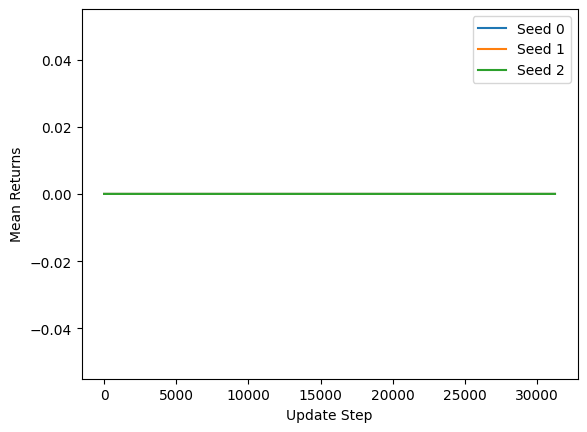

Max steps per seed (reconstructed):
{'Seed 0': (0, 0.0), 'Seed 1': (0, 0.0), 'Seed 2': (0, 0.0)}


In [12]:
# Directory containing the seed files
cluster = "brigit"
load_datetime = '2025-03-30_18-26-42'
load_layout_name = 'custom_10'

# Run the function
show_figure = 1
mean_returns_per_seed, max_steps_per_seed = recreate_results_csv(cluster, load_layout_name, load_datetime, show_figure=show_figure)

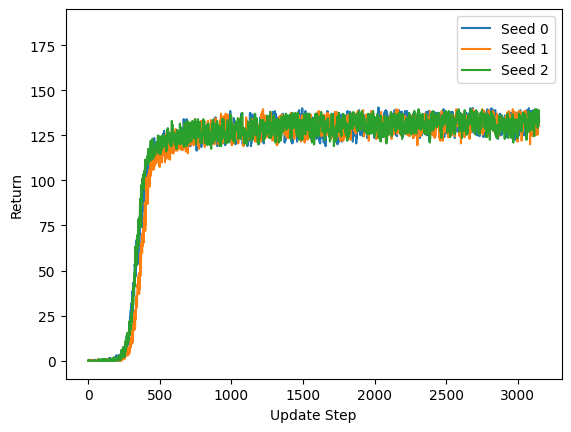

In [25]:
max_steps = int(3.15e3)

plt.figure() 
for i in range(len(mean_returns_per_seed)):    
    plt.plot(mean_returns_per_seed[i][:max_steps], label=f"Seed {i}")

plt.xlabel("Update Step")
plt.ylabel("Return")
plt.ylim(-10, 195)
plt.legend()

if cluster == "cuenca":
    original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
elif cluster == "brigit":
    original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
else:
    print("Introduce a valid cluster name")

save_path = os.path.join(original_dir, f"plot_zoom_{load_layout_name}_{load_datetime}.png")
plt.savefig(save_path)
plt.show()

In [ ]:
def find_value_return_interval(seed, mean_returns_per_seed, config, searched_value, min_step, max_step):
    for step in range(int(min_step), int(max_step + 1)):
        scaled_step = step // config["NUM_STEPS"]  # Adjust step according to NUM_STEPS
        if mean_returns_per_seed[seed][step] == searched_value:
            print(f"First return value {searched_value} in seed {seed} at update_step: {step}. In update step: {scaled_step}")
            return scaled_step

    print(f"No return value {searched_value} found in seed {seed} within the specified range.")
    return None

def find_different_value_return_interval(seed, mean_returns_per_seed, config, searched_value, min_step, max_step):
    for step in range(int(min_step), int(max_step + 1)):
        scaled_step = step // config["NUM_STEPS"]  # Adjust step according to NUM_STEPS
        if mean_returns_per_seed[seed][step] != searched_value:
            print(f"First return value {searched_value} in seed {seed} at update_step: {step}. In update step: {scaled_step}")
            return scaled_step

    print(f"No return value {searched_value} found in seed {seed} within the specified range.")
    return None

In [ ]:
seed = 2
searched_value = 0
min_step = 4e6
max_step = 4.3e6

found_step = find_value_return_interval(seed, mean_returns_per_seed, config, searched_value, min_step, max_step)

In [14]:
def get_trained_steps(load_layout_name, load_datetime, mean_returns_per_seed, min_value, max_value, seed=None):
    if cluster == "cuenca":
        original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    elif cluster == "brigit":
        original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
    else:
        print("Introduce a valid cluster name")
        return

    step_pattern = re.compile(r"trained_model_(\d+)\.pkl")

    results = {}  # Final dictionary with the reconstructed values

    seed_path = os.path.join(original_dir, f"Seed_{seed}")   
    if os.path.isdir(seed_path):
        steps = []
        for file in os.listdir(seed_path):
            step_match = step_pattern.match(file)
            if step_match and min_value <= int(step_match.group(1)) and max_value >= int(step_match.group(1)):
                steps.append(int(step_match.group(1)))

        steps.sort()
        for step in steps:                 
            results[step] = mean_returns_per_seed[seed][step]

    return results

In [21]:
seed = 0
min_value = int(0e0)
max_value = int(4e5)

steps_per_seed = get_trained_steps(load_layout_name, load_datetime, mean_returns_per_seed, min_value, max_value, seed)
print(steps_per_seed)

# Get the key with the maximum value
max_key = max(steps_per_seed, key=steps_per_seed.get)

# Print the key and its corresponding value
print(f"Key with the highest value: {max_key}, Value: {steps_per_seed[max_key]}")

{0: 0.0, 50: 0.0, 100: 0.0, 150: 0.0, 200: 0.0, 250: 0.0, 300: 0.0, 350: 0.0, 400: 0.0, 450: 0.0, 500: 0.0, 550: 0.0, 600: 0.0, 650: 0.0, 700: 0.0, 750: 0.0, 800: 0.0, 850: 0.0, 900: 0.0, 950: 0.0, 1000: 0.0, 1050: 0.0, 1100: 0.0, 1150: 0.0, 1200: 0.0, 1250: 0.0, 1300: 0.0, 1350: 0.0, 1400: 0.0, 1450: 0.0, 1500: 0.0, 1550: 0.0, 1600: 0.0, 1650: 0.0, 1700: 0.0, 1750: 0.0, 1800: 0.0, 1850: 0.0, 1900: 0.0, 1950: 0.0, 2000: 0.0, 2050: 0.0, 2100: 0.0, 2150: 0.0, 2200: 0.0, 2250: 0.0, 2300: 0.0, 2350: 0.0, 2400: 0.0, 2450: 0.0, 2500: 0.0, 2550: 0.0, 2600: 0.0, 2650: 0.5, 2700: 0.0, 2750: 0.0, 2800: 0.0, 2850: 0.50125, 2900: 0.0, 2950: 1.9975001, 3000: 11.502501, 3050: 53.996254, 3100: 74.497505, 3150: 77.497505, 3200: 79.00125, 3250: 80.497505, 3300: 89.505005, 3350: 90.50001, 3400: 94.5025, 3450: 90.99251, 3500: 91.50001, 3550: 93.00001, 3600: 92.99876, 3650: 95.99876, 3700: 94.997505, 3750: 94.0025, 3800: 91.49876, 3850: 94.99876, 3900: 91.50375, 3950: 94.5025, 4000: 96.497505, 4050: 95.00

LOADING AND EVALUATING

In [13]:
fixed_step = 391350  # Change this to the desired step

seed_idx = 0  # Change if needed

#cluster = "brigit"
#load_datetime = '2025-03-26_14-56-22'
#load_layout_name = 'custom_8'
custom_layout = load_custom_layout(load_layout_name)

if cluster == "cuenca":
    original_dir = f'/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
elif cluster == "brigit":
    original_dir = f'/mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/{load_layout_name}/Checkpoints_{load_datetime}/'
else:
    print("Introduce a valid cluster name")

load_dir = f"{original_dir}Seed_{seed_idx}/"
load_filename = f"trained_model_{fixed_step}.pkl"

num_actions = 6
activation = "tanh"

# Initialize network
network_1 = ActorCritic(num_actions, activation)
network_2 = ActorCritic(num_actions, activation)

# Load parameters into the network
model_params_1, model_params_2, closest_step = find_closest_checkpoint(fixed_step, load_dir)

print(f"Model restored successfully from step {closest_step}")

if 'mean_returns_per_seed' in locals() or 'mean_returns_per_seed' in globals():
    return_value = f"{mean_returns_per_seed[seed_idx][closest_step]:.3f}".replace(".", "_")
    print(f"with mean return {float(mean_returns_per_seed[seed_idx][closest_step])}!")

Found checkpoint: trained_model_31249.pkl for step 31249
Model parameters loaded from /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/custom_10/Checkpoints_2025-03-30_18-26-42/Seed_0/trained_model_31249.pkl
Model restored successfully from step 31249
with mean return 0.0!


In [14]:
# Set environment parameters
max_steps = 1000
key = jax.random.PRNGKey(0)
key, key_r, key_a = jax.random.split(key, 3)

# Choose layout
#layout = overcooked_layouts["cramped_room"]
layout = custom_layout

# Instantiate environment
env = make('overcooked', layout=layout, max_steps=max_steps)

# Reset environment
obs, state = env.reset(key_r)
print('List of agents in environment:', env.agents)

# Visualization setup
viz = OvercookedVisualizer()
state_seq = []

List of agents in environment: ['agent_0', 'agent_1']


In [15]:
# Run environment loop using the trained model
for _ in range(max_steps):
    state_seq.append(state)
    
    # Get model-based actions
    key, key_s = jax.random.split(key)
    
    actions = {}
    for i, agent in enumerate(env.agents):
        agent_obs = obs[agent]  # Extract observation for each agent
        
        # Choose the correct network for the current agent
        if i == 0:
            action_logits, value = network_1.apply(model_params_1, agent_obs.flatten())  # Get model's action distribution
        elif i == 1:
            action_logits, value = network_2.apply(model_params_2, agent_obs.flatten())  # Get model's action distribution
        
        action = action_logits.sample(seed=key_s)
        key, key_s = jax.random.split(key)

        actions[agent] = action
    
    # Step environment
    obs, state, rewards, dones, infos = env.step(key_s, state, actions)

In [16]:
# FIX VISUALIZATION (SAVING IT WORKS)

# Render to screen
#for s in state_seq:
#    viz.render(env.agent_view_size, s, highlight=False)
#    time.sleep(0.1)

# Save animation
agent_view_size = 5

output_filename = f"{load_dir}/animation_{load_layout_name}_trained_model_{load_datetime}_step_{closest_step}_value_{return_value}.gif"

custom_animate(state_seq, agent_view_size=agent_view_size, filename=output_filename)

print(f"Animation saved to {output_filename} with adjusted speed")

gif_to_mp4(output_filename)

Animation saved to /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/custom_10/Checkpoints_2025-03-30_18-26-42/Seed_0//animation_custom_10_trained_model_2025-03-30_18-26-42_step_31249_value_0_000.gif with adjusted speed


/home/samuloza/.conda/envs/JaxMARL/lib/python3.12/subprocess.py:1893: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


MP4 saved to /mnt/lustre/home/samuloza/data/samuel_lozano/hfsp_collective_learning/data_JaxMARL/Asymmetric_Agents/custom_10/Checkpoints_2025-03-30_18-26-42/Seed_0//animation_custom_10_trained_model_2025-03-30_18-26-42_step_31249_value_0_000.mp4
